<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/feat%2Flatitude-longitude-compensation/Dacon_satellite_outlier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
 
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
tf.__version__

'2.2.0'

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

## 데이터 받아오기

In [5]:
# 훈련 데이터 및 자가 test데이터 불러오기
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/train_total_32bits.npy')
print(train.shape)
print(train.dtype)
gmi_preci = np.load('/content/drive/My Drive/2020 Kaggle Study/data/gmi_preci_32bits.npy')
print(gmi_preci.shape)
print(gmi_preci.dtype)

(76345, 40, 40, 15)
float32
(76345, 40, 40, 1)
float32


## 이상치 처리

In [0]:
# 이상치 최대값으로 치환

# train[:,:,:,2].reshape(-1)[train[:,:,:,2].reshape(-1)>500] = 500
# train[:,:,:,3].reshape(-1)[train[:,:,:,3].reshape(-1)>500] = 500
# train[:,:,:,5].reshape(-1)[train[:,:,:,5].reshape(-1)>350] = 350
# train[:,:,:,6].reshape(-1)[train[:,:,:,6].reshape(-1)>350] = 350

In [0]:
# Robust Scaler

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 15))
train_scaled = train_scaled.reshape(train.shape)

In [0]:
land_type_data = train[:,:,:,9]
land_type_data = np.where(land_type_data//100 == 2, 0.8,
                          np.where(land_type_data//100 == 3, 0.1,
                                   land_type_data//100))
train_scaled[:,:,:,9] = land_type_data
train_scaled[:,:,:,-1] = gmi_preci.reshape(-1, 40, 40)  # GMI precipatation

## 모델만들기

In [0]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 10))
output_layer = build_model(input_layer, 32)

In [0]:
model = Model(input_layer, output_layer)

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## Training

In [13]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle = True)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train_scaled):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
#-----------------------------------------------------------------------------
    def trainGenerator():
        for file in train_scaled[train_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1) ############################# error나서 배치사이즈 조절: 512 -> 32
#-----------------------------------------------------------------------------
    def testGenerator():
        for file in train_scaled[test_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(test_size).prefetch(1) ################################ error나서 배치사이즈 조절: test_size -> 32
#-----------------------------------------------------------------------------

    

    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)

    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10
77/77 [==============================] - 66s 853ms/step - loss: 0.2241 - maeOverFscore_keras: 3.2720 - fscore_keras: 0.5172 - val_loss: 0.1867 - val_maeOverFscore_keras: 2.6335 - val_fscore_keras: 0.5551
Epoch 2/10
77/77 [==============================] - 64s 835ms/step - loss: 0.1636 - maeOverFscore_keras: 1.8783 - fscore_keras: 0.6659 - val_loss: 0.1763 - val_maeOverFscore_keras: 2.2183 - val_fscore_keras: 0.6204
Epoch 3/10
77/77 [==============================] - 66s 854ms/step - loss: 0.1540 - maeOverFscore_keras: 1.6667 - fscore_keras: 0.7024 - val_loss: 0.1624 - val_maeOverFscore_keras: 1.8349 - val_fscore_keras: 0.6873
Epoch 4/10
77/77 [==============================] - 67s 870ms/step - loss: 0.1487 - maeOverFscore_keras: 1.5551 - fscore_keras: 0.7243 - val_loss: 0.1568 - val_maeOverFscore_keras: 1.7828 - val_fscore_keras: 0.6827
Epoch 5/10
77/77 [==============================] - 66s 862ms/step - loss: 0.1464 - maeOverFscore_keras: 1.5136 - fscore_keras: 0.73

## 모델 저장 및 plotting

In [0]:
## 모델 저장하기
model.save('model_scaled.h5')
!cp model_scaled.h5 '/content/drive/My Drive/2020 Kaggle Study/model/model_scaled.h5'

In [15]:
# model = tf.keras.models.load_model('/content/drive/My Drive/2020 Kaggle Study/model')

OSError: ignored

In [0]:
def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['maeOverFscore_keras'], label='maeOverFscore_keras')
    plt.plot(np.arange(0, epoch), his.history['val_maeOverFscore_keras'], label='val_maeOverFscore_keras')
    plt.title(title)
    plt.xlabel(f'Epoch {epoch}')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

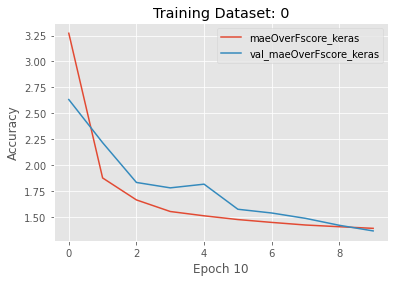

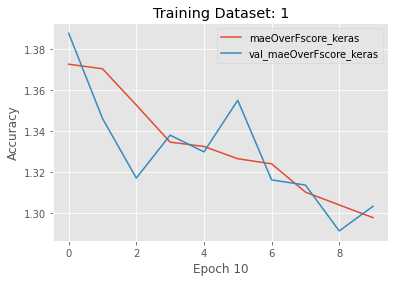

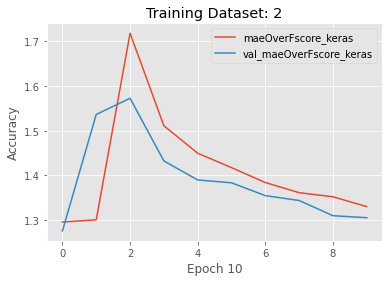

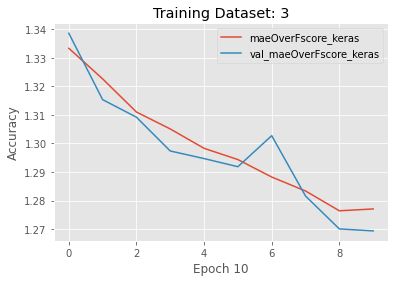

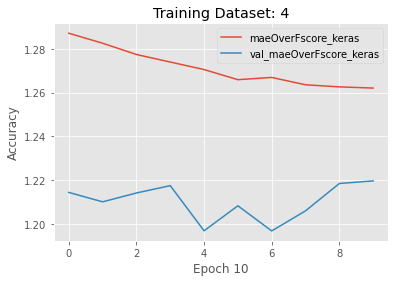

In [18]:
for dataset in range(5):
    #plot_loss(model_history[dataset], 10 , f'Training Dataset: {dataset}')
    plot_acc(model_history[dataset], 10 , f'Training Dataset: {dataset}')

In [0]:
del train
del train_scaled

## submission 만들기

In [0]:
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')

# test_submit에 대해서도 똑같이 전처리
# test_submit[:,:,:,2].reshape(-1)[test_submit[:,:,:,2].reshape(-1)>500] = 500
# test_submit[:,:,:,3].reshape(-1)[test_submit[:,:,:,3].reshape(-1)>500] = 500
# test_submit[:,:,:,5].reshape(-1)[test_submit[:,:,:,5].reshape(-1)>350] = 350
# test_submit[:,:,:,6].reshape(-1)[test_submit[:,:,:,6].reshape(-1)>350] = 350

# land_type, latitude, longitude copy
land_type_data = test_submit[:,:,:,9].copy()
gmi_lat_lon = test_submit[:,:,:,10:12].copy()
dpr_lat_lon = test_submit[:,:,:,12:14].copy()

dummy = np.random.rand(test_submit.shape[0], 40, 40, 1)
test_submit = np.concatenate((test_submit, dummy), axis=3)
test_shape = test_submit.shape
test_submit = scaler.transform(test_submit.reshape(-1, 15))
test_submit = test_submit.reshape(test_shape)

land_type_data = np.where(land_type_data//100 == 2, 0.8,
                          np.where(land_type_data//100 == 3, 0.1,
                                   land_type_data//100))
test_submit[:,:,:,9] = land_type_data
test_submit[:,:,:,10:12] = gmi_lat_lon
test_submit[:,:,:,12:14] = dpr_lat_lon

In [0]:
# 훈련에서 사용하는 0~8번 채널, ladtype 만을 뽑아내기
pred = model.predict(test_submit[:,:,:,:10])
test_submit[:,:,:,-1] = pred.reshape(-1, 40, 40)

In [23]:
test_submit.shape

(2416, 40, 40, 15)

## GMI precipatation -> DPR precipatation

In [0]:
dr = [(-1, -1), (-1, 0), (-1, 1),
      (0, -1), (0, 0), (0, 1),
      (1, -1), (1, 0), (1, 1)]

# p1, p2: shape=(-1, 2).
def get_dist(p1, p2):
    x1 = np.deg2rad(p1[:,0])
    y1 = np.deg2rad(p1[:,1])
    x2 = np.deg2rad(p2[:,0])
    y2 = np.deg2rad(p2[:,1])
    dlon = x2 - x1
    dlat = y2 - y1
    a = np.sin(dlat/2)**2 + np.cos(y1) * np.cos(y2) * np.sin(dlon/2)**2 
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))    
    return 6373.0 * c  # km, shape=(-1).

# ori_ll에서의 value 값을 tgt_ll에 대한 값으로 바꾼다.
# value: (40, 40, -1)
# ori_ll, tgt_ll: (40, 40, 2)
# ori_ll: value에 대응되는 원래 latitude, longitude.
# tgt_ll: 변환되는 값에 대응되는 latitude, longitude.
def compen_ll(value, ori_ll, tgt_ll):
    ret = np.empty_like(value)

    n = value.shape[0]
    m = value.shape[1]

    for i in range(n):
        for j in range(m):
            nears = []  # (row, col, value)
            for k in range(9):
                ii = i + dr[k][0]
                jj = j + dr[k][1]
                if ii >= 0 and ii < n and jj >= 0 and jj < m:
                    nears.append((ori_ll[ii, jj][0], ori_ll[ii, jj][1],
                                  tgt_ll[i, j][0], tgt_ll[i, j][1],
                                  value[ii, jj]))

            nears = np.array(nears)  # shape=(-1, 5)
            dists = get_dist(nears[:, 0:2], nears[:, 2:4]).reshape(-1, 1)
            values = nears[:, 4].reshape(-1, 1)
            nears = np.concatenate((dists, values), 1)
            nears = nears[np.argsort(nears[:, 0])]  # sort by dist

            weights = 1 / (nears[:, 0] ** 2 + sys.float_info.epsilon)
            weighted_sum = (weights * nears[:, 1]).sum()
            ret[i, j] = weighted_sum / weights.sum()
    return ret

In [26]:
import sys
from multiprocessing import Process, Manager

n_procs = 4
procs = []
manager = Manager()
dpr_preci = manager.list([None] * n_procs)

# split train into n_procs arrays
n_imgs = test_submit.shape[0]
splitted = np.split(test_submit, np.arange((n_imgs + n_procs - 1) // n_procs,
                                     n_imgs, n_imgs // n_procs))

def proc_func(proc_id):
    part = splitted[proc_id]
    arr = np.empty_like(part[:, :, :, 14])  # shape=(-1, 40, 40)
    for i in range(part.shape[0]):
        arr[i, :, :] = compen_ll(part[i, :, :, 14],
                                 part[i, :, :, 10:12],
                                 part[i, :, :, 12:14])
        if (i + 1) % 200 == 0:
            print(proc_id, i + 1)
    dpr_preci[proc_id] = arr

for proc_id in range(n_procs):
    proc = Process(target=proc_func, args=(proc_id, ))
    proc.start()
    procs.append(proc)

for proc in procs:
    proc.join()

dpr_preci = np.concatenate(dpr_preci)
dpr_preci = dpr_preci.reshape(-1, 40, 40, 1)
# dpr_preci = dpr_preci.astype(np.float32)

0 200
2 200
1 200
3 200
1 400
3 400
2 400
0 400
1 600
2 600
0 600
3 600


## submission 만들기

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = dpr_preci.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_scaled4.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_scaled4.csv '/content/drive/My Drive/2020 Kaggle Study/submission'

In [31]:
submission

,id,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,px_10,px_11,px_12,px_13,px_14,px_15,px_16,px_17,px_18,px_19,px_20,px_21,px_22,px_23,px_24,px_25,px_26,px_27,px_28,px_29,px_30,px_31,px_32,px_33,px_34,px_35,px_36,px_37,px_38,px_39,...,px_1561,px_1562,px_1563,px_1564,px_1565,px_1566,px_1567,px_1568,px_1569,px_1570,px_1571,px_1572,px_1573,px_1574,px_1575,px_1576,px_1577,px_1578,px_1579,px_1580,px_1581,px_1582,px_1583,px_1584,px_1585,px_1586,px_1587,px_1588,px_1589,px_1590,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
0,029858_01,0.102095,0.062762,0.011353,0.012498,0.057899,0.177565,0.197151,0.103024,0.019760,0.01638,0.214829,0.448802,0.189583,0.025750,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000242,0.006972,0.057820,0.109414,0.109054,0.023099,0.000868,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,029858_02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.005399,0.119644,0.046114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,029858_03,0.000000,0.000000,0.000000,0.007899,0.008278,0.002957,0.000191,0.000000,0.000000,0.00016,0.005354,0.025669,0.007597,0.009045,0.011007,0.006041,0.000559,0.000000,0.000000,0.00000,0.0,0.000284,0.000345,0.011114,0.088569,0.041187,0.006919,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,029858_05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000052,0.010665,0.209717,0.857449,0.729379,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001606,0.04475,0.893620,2.088482,2.582431,1.326185,0.209332,0.003475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,029858_07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.960976,1.159308,1.240561,1.721525,2.275647,2.258308,1.575496,0.82008,0.657166,1.071895,2.267492,3.644793,4.192590,4.788139,6.491947,10.130253,15.531141,19.618919,20.972444,18.137113,14.137342,11.974325,14.993391,16.135236,10.145117,2.959914,0.954125,0.304295,0.344497,0.627374,1.134565,1.540524,1.29413,0.959068,1.254579,2.109486,3.354363